In [1]:
!pip install datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
data = pd.read_csv("/content/Combined Data.csv")
data.dropna(inplace=True)
data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
data = data.sample(n=6000, random_state=42).reset_index(drop=True)


In [3]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

def clean_statement(text):
    text = text.lower()
    text = re.sub(r"[^A-Za-z\s]", '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

data['statement'] = data['statement'].apply(clean_statement)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

X = data.drop(columns=['status'])
y = data['status']

X_resampled, y_resampled = ros.fit_resample(X, y)
data = pd.concat([X_resampled, y_resampled], axis=1)


In [5]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])


In [6]:
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'], test_size=0.2)


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})


In [9]:
model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2,
    fp16=True  # Enable mixed precision training
)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerN

In [10]:
model.to('cuda')


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,2.362200,1.087864
2,0.957200,0.435823
3,0.578200,0.317538
4,0.508900,0.322723
5,0.379900,0.306926


TrainOutput(global_step=3315, training_loss=1.2520026325640097, metrics={'train_runtime': 989.7233, 'train_samples_per_second': 53.581, 'train_steps_per_second': 3.349, 'total_flos': 5450549081100000.0, 'train_loss': 1.2520026325640097, 'epoch': 5.0})

                      precision    recall  f1-score   support

             Anxiety       0.95      0.99      0.97       368
             Bipolar       0.97      0.99      0.98       393
          Depression       0.75      0.62      0.68       409
              Normal       0.92      0.88      0.90       377
Personality disorder       1.00      1.00      1.00       353
              Stress       0.94      0.99      0.97       370
            Suicidal       0.72      0.78      0.75       382

            accuracy                           0.89      2652
           macro avg       0.89      0.90      0.89      2652
        weighted avg       0.89      0.89      0.89      2652



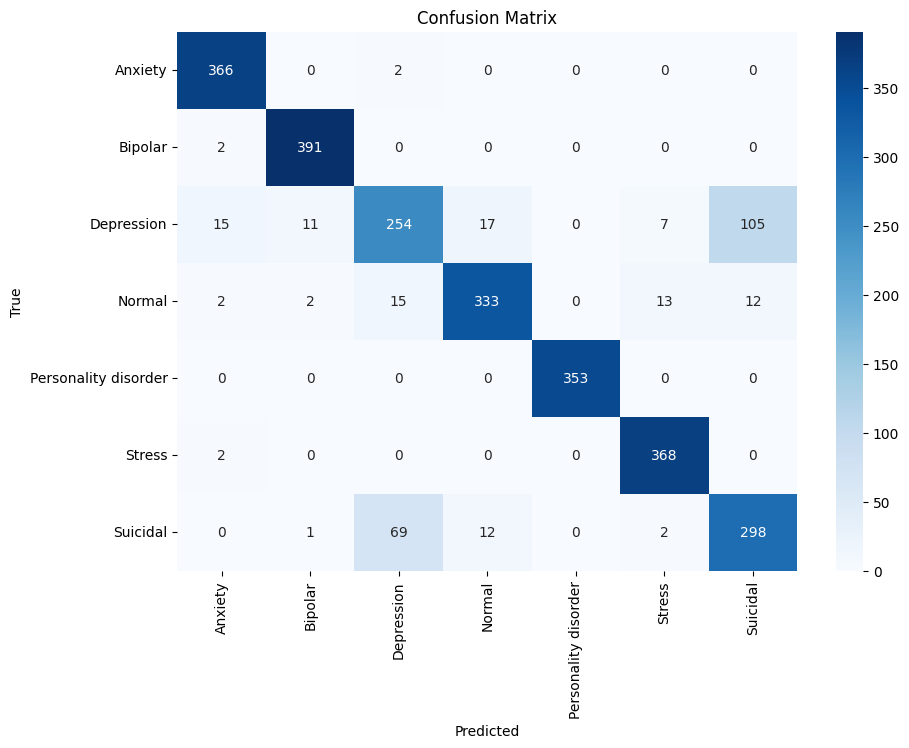

In [19]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Save the trained model and tokenizer
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/saved_mental_status_bert")  # Save the model to the specified directory
tokenizer.save_pretrained("/content/drive/MyDrive/Colab Notebooks/saved_mental_status_bert")  # Save the tokenizer


import pickle

pickle.dump(label_encoder, open('/content/drive/MyDrive/Colab Notebooks/label_encoder.pkl', 'wb'))

In [17]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved paths
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Colab Notebooks/saved_mental_status_bert")

label_encoder = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/label_encoder.pkl', 'rb'))

Detection System

In [18]:
# Detection System (Example)
def detect_anxiety(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Test detection system with a mixture of normal, anxiety, bipolar, depression, suicide, etc.
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I can't stop thinking about what will happen if things go wrong.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]

# Assuming the detect_anxiety function is already defined and takes a sentence as input
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")

Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: Normal

Sentence: I can't stop thinking about what will happen if things go wrong.
Predicted class: Normal

Sentence: Lately, I've been on a high, feeling like I can do anything!
Predicted class: Stress

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: Normal

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: Normal

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: Suicidal

Sentence: I had a really good day, spent some time with my friends.
Predicted class: Normal

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: Normal

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: Suicidal

Sentence: I'm okay today, but sometimes I get really anxious for no reason.
Predicted class: Anxiety

